# A simple nb to learn about backpropagation on neural nets

reference: **Andrej Karpathy** - The spelled-out intro to neural networks and backpropagation: building micrograd

video: https://www.youtube.com/watch?v=VMj-3S1tku0&t=4943s

github **micrograd**: https://github.com/karpathy/micrograd

### Starting with a simple view of derivatives

In [147]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
def f(x):
    return 3*x**2 - 4*x +5

In [149]:
f(3.0)

20.0

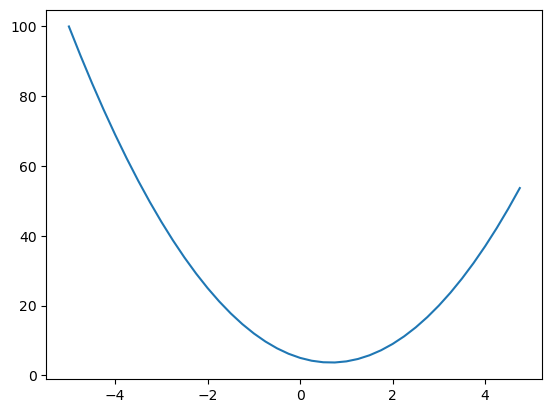

In [150]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [151]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x))/h

2.9753977059954195e-07

In [152]:
# a bit more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [153]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)

# get slope
print('slope', (d2-d1)/h)

# changing b
a -= h
b += h
d2 = a*b +c

# get slope
print('slope 2', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772
slope 2 2.0000000000042206


### Start with classes representing a scalar

In [188]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else  Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else  Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only int and float powers'
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __radd__(self, other): # other + self
        return self + other

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rtruediv__(self, other): # other / self
        return other * self**-1



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(2.0, label='f')
L = d + f; L.label = 'L'

d

Value(data=4.0)


### Adding visualization

For extra info check: https://graphviz.readthedocs.io/en/stable/manual.html

In [155]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

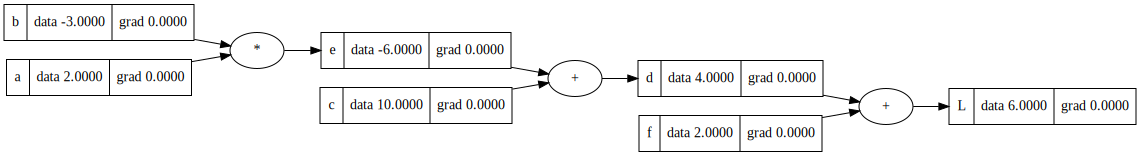

In [156]:
draw_dot(L)

### Graphical visualization of tanh

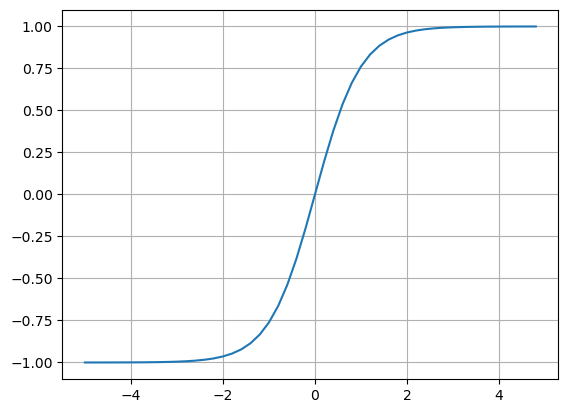

In [157]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

### Crating a neuron

In [158]:
# inputs x1, x2
# weights w1, w2
# bias b

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735, label='b')

# compute sinapses

x1w1 = x1*w1; x1w1.label= 'x1*w1'
x2w2 = x2*w2; x2w2.label= 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 +b; n.label = 'n' # cell body without activation

o = n.tanh(); o.label = 'o'



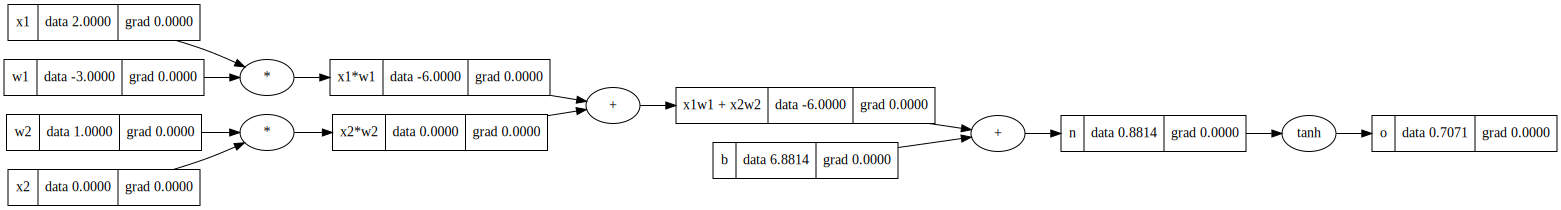

In [159]:
draw_dot(o)

In [160]:
o.backward()

### checking a bug
a + a does not increment the grad

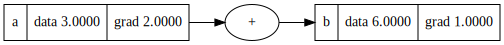

In [161]:
a = Value(3.0, label='a')
b = a +a ; b.label = 'b'

b.backward()
draw_dot(b)

### Adding += to grad

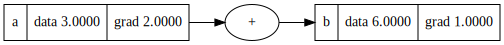

In [162]:
a = Value(3.0, label='a')
b = a +a ; b.label = 'b'

b.backward()
draw_dot(b)

In [163]:
2 * a
a * 2

Value(data=6.0)

### adding __rmul__ to accept 2 * a

In [164]:
2 * a
a * 2

Value(data=6.0)

In [165]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [166]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [167]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

### Draw the new diagram

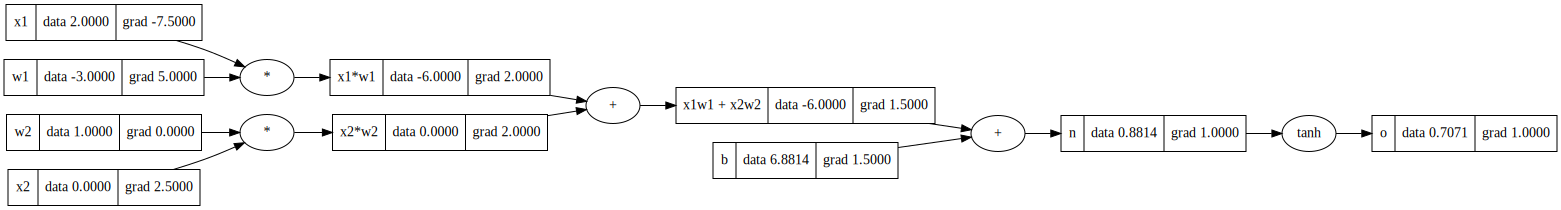

In [168]:
o.backward()
draw_dot(o)

### defining the tanh in a different way

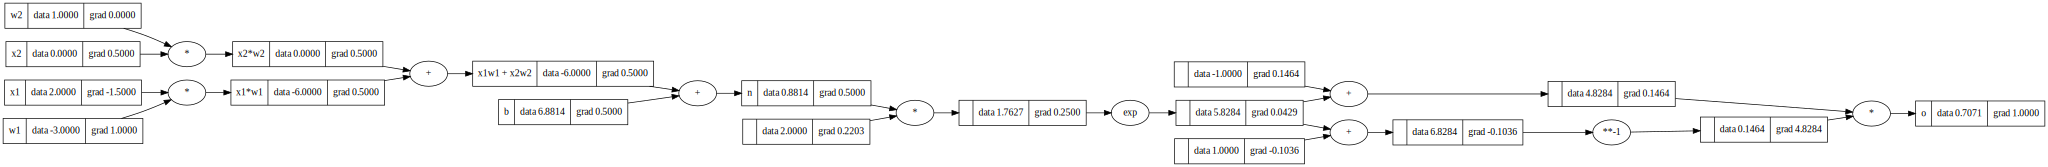

In [169]:
# inputs x1, x2
# weights w1, w2
# bias b

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735, label='b')

# compute sinapses

x1w1 = x1*w1; x1w1.label= 'x1*w1'
x2w2 = x2*w2; x2w2.label= 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 +b; n.label = 'n' # cell body without activation
# -------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -------
o.label = 'o'
o.backward()
draw_dot(o)



# Moving to pytorch

In [170]:
import torch

In [171]:
# using torch

x1 = torch.Tensor([2.0]).double()      ;x1.requires_grad = True   
x2 = torch.Tensor([0.0]).double()      ;x2.requires_grad = True 
w1 = torch.Tensor([-3.0]).double()     ;w1.requires_grad = True 
w2 = torch.Tensor([1.0]).double()      ;w2.requires_grad = True 
b = torch.Tensor([6.8813735]).double() ;b.requires_grad = True   

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---') # check values accuracy our micrograd
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [172]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])

In [173]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [174]:
o.item()

0.7071066904050358

## This shows that our class Value somehow achieves the same as in pytorch Tensors 

-----------------

# Next step: Try to create models with it

In [175]:
import random

In [181]:
2 + x1

tensor([4.], dtype=torch.float64, grad_fn=<AddBackward0>)

In [210]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

# adding layers
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

# mlp - multi layer perceptron
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [228]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9885035432396979)

In [213]:
n.parameters()

[Value(data=-0.21525780125079885),
 Value(data=0.23871764413137853),
 Value(data=0.8888924757182959),
 Value(data=-0.81888073856178),
 Value(data=-0.01387422267482008),
 Value(data=-0.6195649756569817),
 Value(data=0.19296685028365967),
 Value(data=-0.5873659182474595),
 Value(data=-0.914535688404126),
 Value(data=-0.6157565189202374),
 Value(data=0.8494472754562696),
 Value(data=-0.2465134789161585),
 Value(data=0.7523251028451008),
 Value(data=0.7184715928396463),
 Value(data=-0.23398391752246916),
 Value(data=-0.4289711062243118),
 Value(data=0.9336676372010924),
 Value(data=-0.6295080637073944),
 Value(data=-0.3672372710896219),
 Value(data=0.4382165468645782),
 Value(data=-0.13713142244451126),
 Value(data=0.6893348396279035),
 Value(data=0.5365572513559529),
 Value(data=0.1061194957553766),
 Value(data=-0.7256640617479726),
 Value(data=0.748747610303029),
 Value(data=-0.6584161407643174),
 Value(data=-0.5924533960591587),
 Value(data=-0.4528622079443785),
 Value(data=-0.062725722

### understanding the loss

In [214]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # wanted outputs

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.7027641915783575),
 Value(data=-0.087454660256705),
 Value(data=-0.5274622811237276),
 Value(data=-0.5980486126020295)]

In [215]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.509196153208765)

### let's try to decrease the loss, with backpropagation

In [225]:
loss.backward()

In [217]:
n.layers[0].neurons[0].w[0].grad

-0.026732540042335773

### only changing weights and bias

In [218]:
n.layers[0].neurons[0].w[0].data

-0.21525780125079885

In [226]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [220]:
n.layers[0].neurons[0].w[0].data

-0.2149904758503755

In [227]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.1208135579764607)

### loss is decreading - backward + change of w and b + calculate loss

applying a gradient descent


In [232]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8813519366066912)

In [233]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # wanted outputs

In [234]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 3.625754491033741
1 0.5338894295435412
2 0.32418303022343786
3 0.22902067935825796
4 0.17558563880466688
5 0.1416548070676991
6 0.1183175672552404
7 0.10134139561022597
8 0.08846937896609586
9 0.07839241632447852
10 0.07030092786130085
11 0.06366832767300218
12 0.05813782891774645
13 0.053459402514361744
14 0.049452799602767224
15 0.04598490252902694
16 0.042955333422164343
17 0.04028701668661348
18 0.03791981818376364
19 0.03580615377634066
